In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import astropy.units as u
import astropy.constants as c
import pandas as pd
from p_winds import tools, parker, hydrogen, helium, transit, microphysics
%config InlineBackend.figure_format = 'retina'
pylab.rcParams['figure.figsize'] = 16.0,6.5
pylab.rcParams['font.size'] = 18

In [6]:
# HD 209458 b planetary parameters, measured
R_pl = 2.085  # Planetary radius in Jupiter radii
M_pl = 0.34  # Planetary mass in Jupiter masses
impact_parameter = 0.499  # Transit impact parameter

# A few assumptions about the planet's atmosphere
m_dot = 10 ** 10.27  # Total atmospheric escape rate in g / s
T_0 = 9100  # Wind temperature in K
h_fraction = 0.90  # H number fraction
he_fraction = 1 - h_fraction  # He number fraction
he_h_fraction = he_fraction / h_fraction
mean_f_ion = 0.0  # Mean ionization fraction (will be self-consistently calculated later)
mu_0 = (1 + 4 * he_h_fraction) / (1 + he_h_fraction + mean_f_ion)  
# mu_0 is the constant mean molecular weight (assumed for now, will be updated later)

In [7]:
df = pd.read_csv('C:/Users/jojoa/GitHub/disperse/data/HPF/HPF_HAT_P_67_20200614_exosphere.csv')

In [8]:
wl=df['wl']
flux=df['flux']

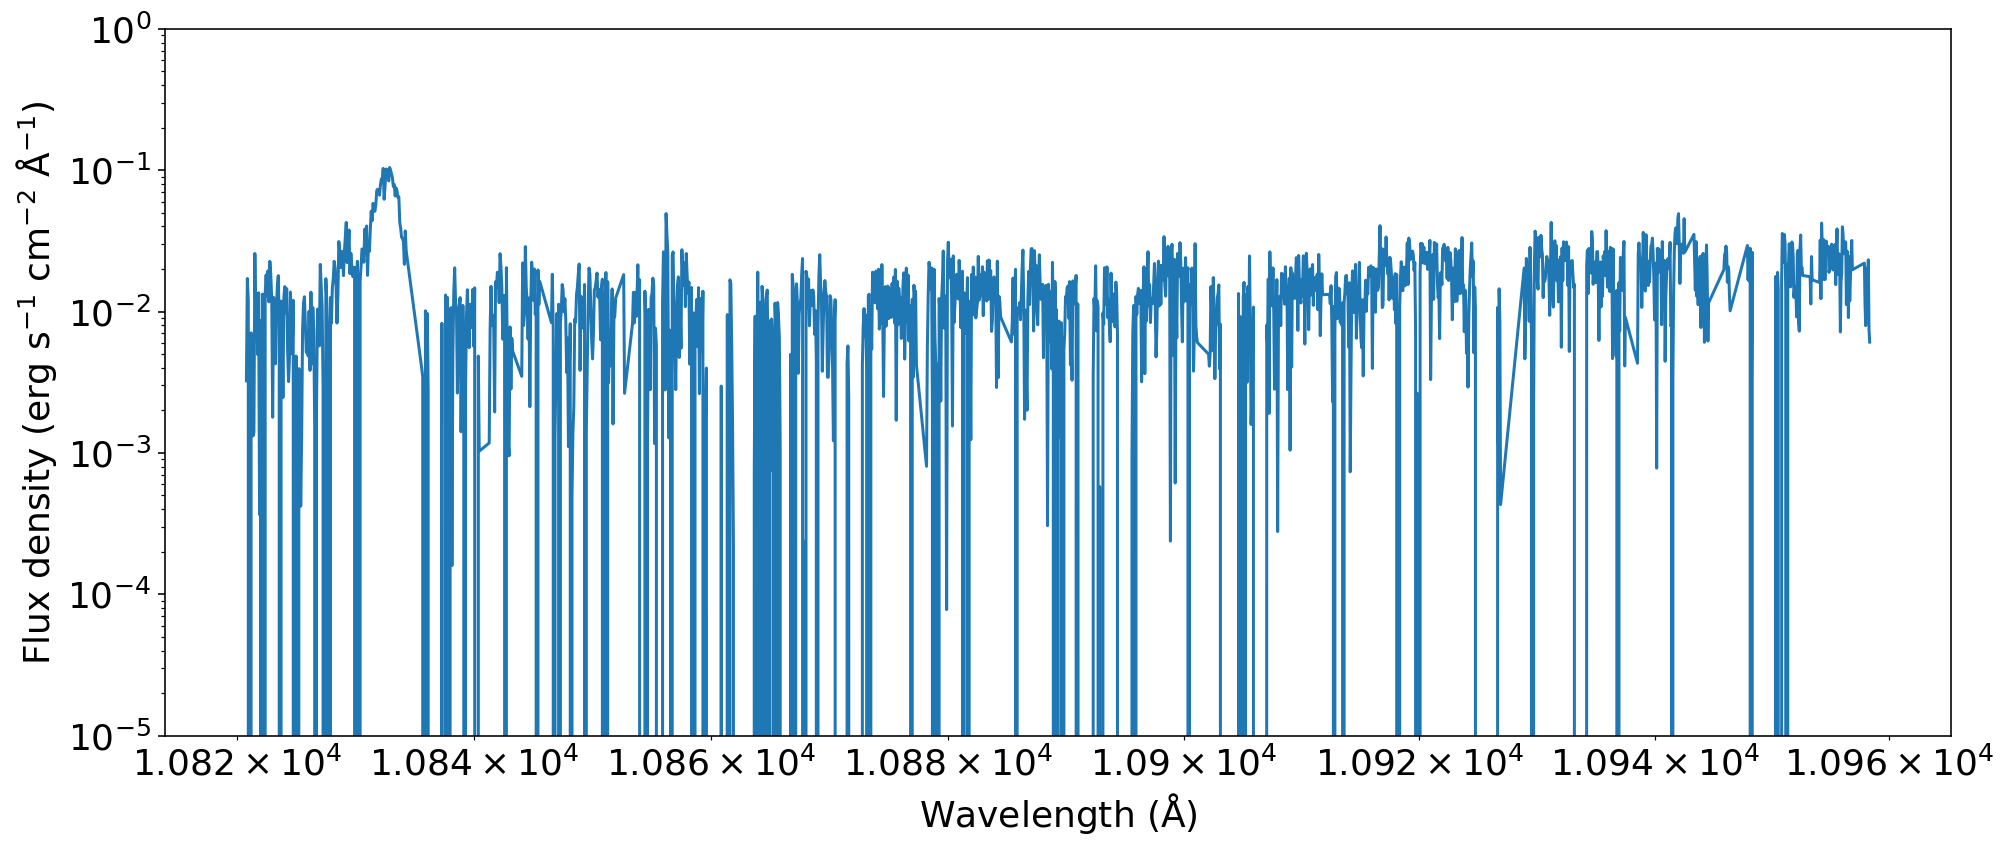

In [9]:
units = {'wavelength': u.angstrom, 'flux': u.erg / u.s / u.cm ** 2 / u.angstrom}
plt.loglog(wl, flux)
plt.ylim(1E-5, 1E0)
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel(r'Flux density (erg s$^{-1}$ cm$^{-2}$ ${\rm \AA}^{-1}$)')
plt.show()

In [10]:
spectrum = tools.make_spectrum_from_file('C:/Users/jojoa/GitHub/disperse/data/HPF/HPF_HAT_P_67_20200614_exosphere_2.txt',
                                    units)

In [11]:
initial_f_ion = 0.0
r = np.logspace(0, np.log10(20), 100)  # Radial distance profile in unit of planetary radii

f_r, mu_bar = hydrogen.ion_fraction(r, R_pl, T_0, h_fraction, 
                            m_dot, M_pl, mu_0,
                            spectrum_at_planet=spectrum, exact_phi=True,
                            initial_f_ion=initial_f_ion, relax_solution=True,
                            return_mu=True)

c:\users\jojoa\github\p-winds\p_winds\microphysics.py:47: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (911.65 / wavelength - 1) ** 0.5
c:\users\jojoa\github\p-winds\p_winds\hydrogen.py:484: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(f_r - previous_f_r) / np.sum(previous_f_r))


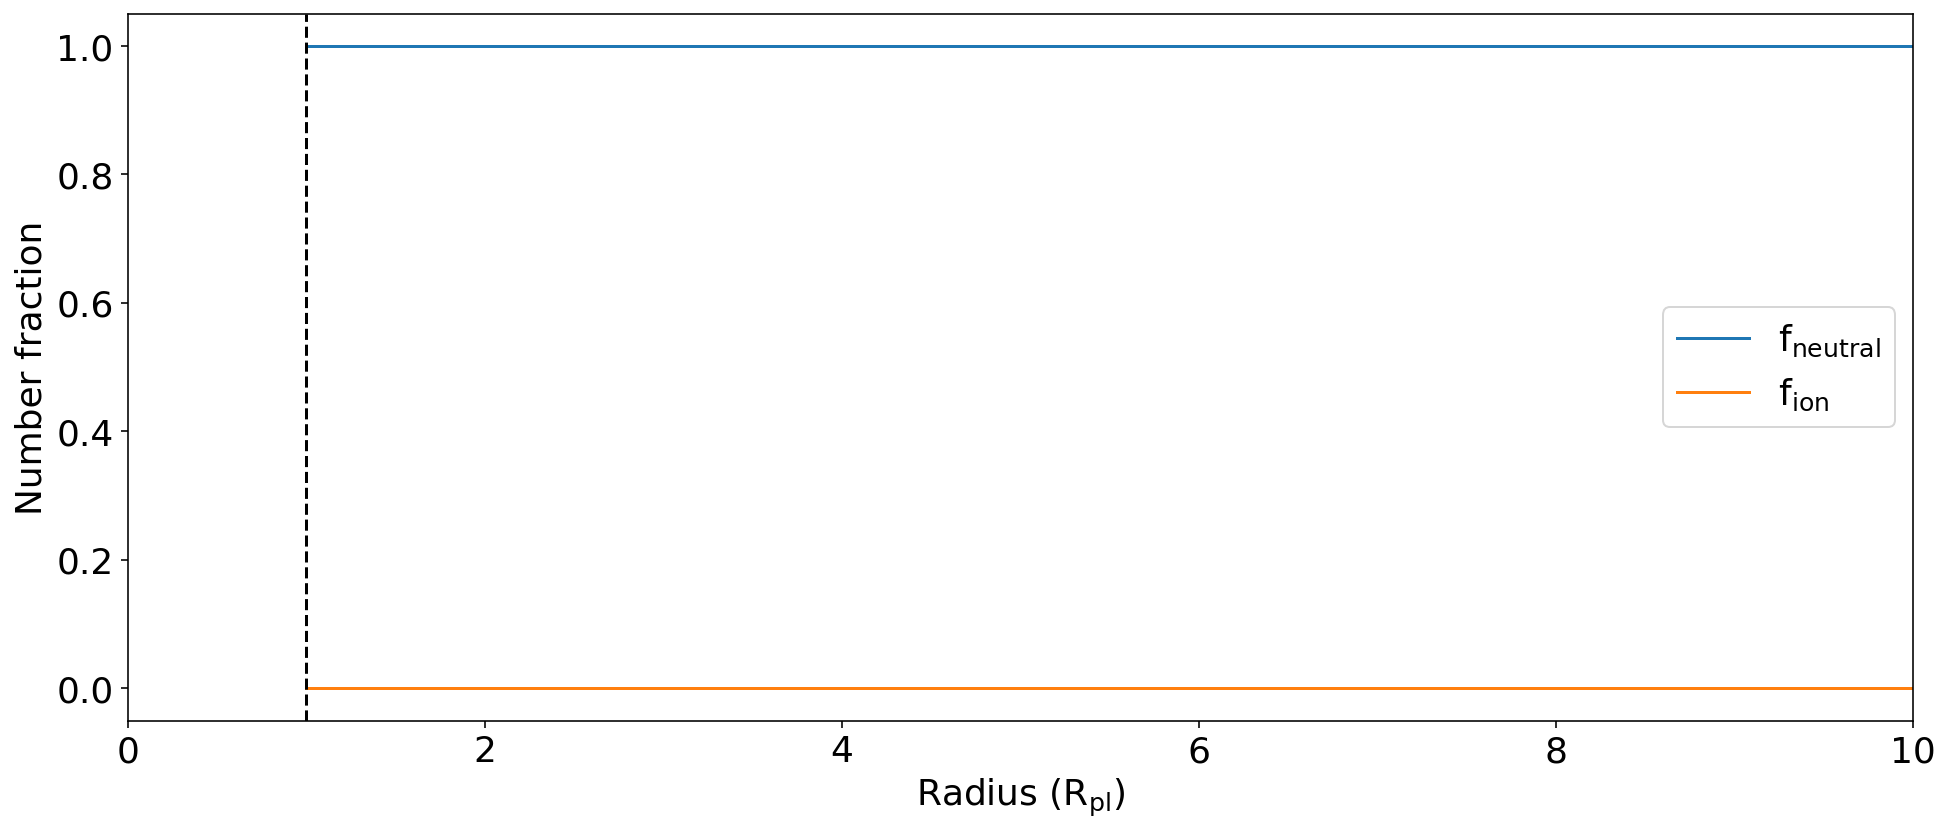

In [12]:
f_ion = f_r
f_neutral = 1 - f_r

plt.plot(r, f_neutral, color='C0', label='f$_\mathrm{neutral}$')
plt.plot(r, f_ion, color='C1', label='f$_\mathrm{ion}$')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number fraction')
plt.xlim(0, 10)
#plt.ylim(0, 1)
plt.axvline(1,color='k',linestyle='--') #surface of atmosphere
plt.legend()
plt.show()

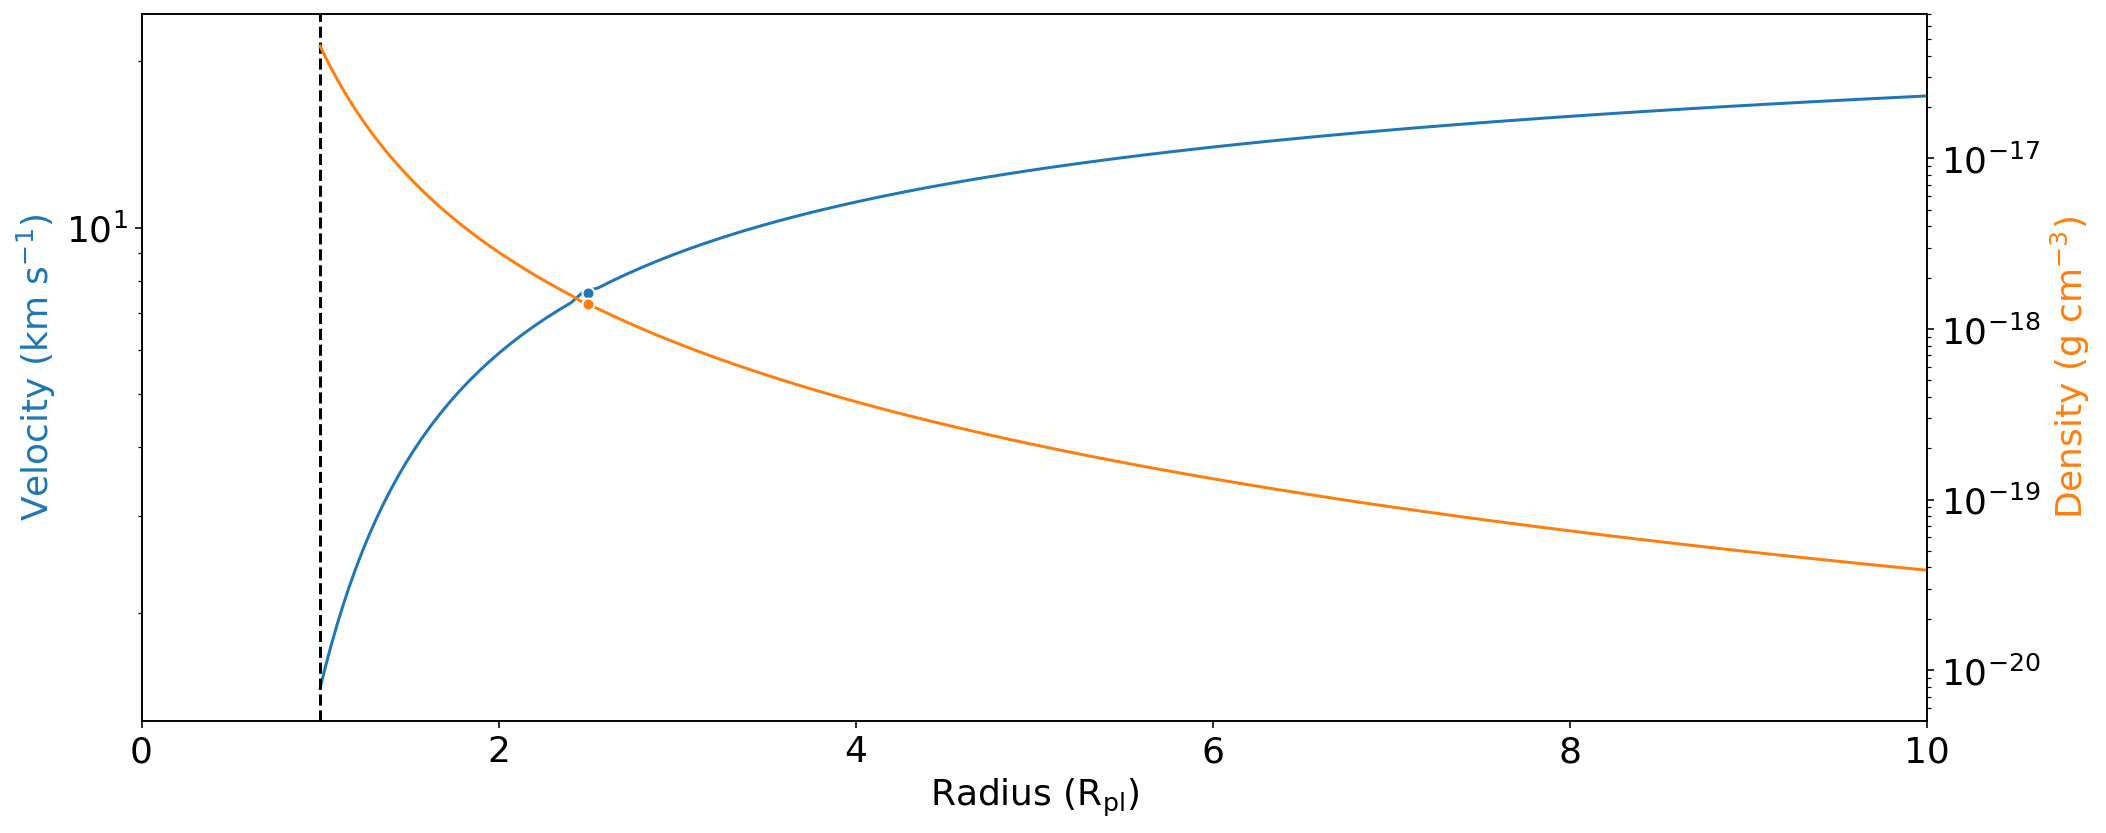

In [13]:
vs = parker.sound_speed(T_0, mu_bar)  # Speed of sound (km/s, assumed to be constant)
rs = parker.radius_sonic_point(M_pl, vs)  # Radius at the sonic point (jupiterRad)
rhos = parker.density_sonic_point(m_dot, rs, vs)  # Density at the sonic point (g/cm^3)

r_array = r * R_pl / rs
v_array, rho_array = parker.structure(r_array)

# Convenience arrays for the plots
r_plot = r_array * rs / R_pl
v_plot = v_array * vs
rho_plot = rho_array * rhos

# Finally plot the structure of the upper atmosphere
# The circles mark the velocity and density at the sonic point
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.semilogy(r_plot, v_plot, color='C0')
ax1.plot(rs / R_pl, vs, marker='o', markeredgecolor='w', color='C0')
ax2.semilogy(r_plot, rho_plot, color='C1')
ax2.plot(rs / R_pl, rhos, marker='o', markeredgecolor='w', color='C1') #point where atmosphere escapes
ax1.set_xlabel(r'Radius (R$_{\rm pl}$)')
ax1.set_ylabel(r'Velocity (km s$^{-1}$)', color='C0')
ax2.set_ylabel(r'Density (g cm$^{-3}$)', color='C1')
ax1.set_xlim(0, 10)
ax1.axvline(1,color='k',linestyle='--') #surface of atmosphere
plt.show()

In [15]:
# In the initial state, the fraction of singlet and triplet helium 
# are, respectively, 1.0 and 0.0
initial_state = np.array([1.0, 0.0])
f_he_1, f_he_3 = helium.population_fraction(
    r, v_array, rho_array, f_ion,
    R_pl, T_0, h_fraction, vs, rs, rhos, spectrum_at_planet=spectrum,
    initial_state=initial_state, relax_solution=True)

IndexError: index -1 is out of bounds for axis 0 with size 0

In [16]:
spectrum

{'wavelength': array([10820.82854, 10820.90764, 10820.98673, ..., 10958.20273,
        10958.2592 , 10958.31567]),
 'flux_lambda': array([0.00323556, 0.01714036, 0.01194248, ..., 0.02325366, 0.00750247,
        0.00608153]),
 'wavelength_unit': Unit("Angstrom"),
 'flux_unit': Unit("erg / (Angstrom cm2 s)")}

In [17]:
#Does it not work because the spectrum_at_planet does not cover until 2593 Angstroms? Spectrum of the host star arriving
#at the planet covering fluxes at least up to the wavelength corresponding to the energy to populate the helium states 
#(4.8 eV, or 2593 Angstrom).

In [ ]:
# Hydrogen atom mass
m_h = c.m_p.to(u.g).value

# Number density of helium nuclei 
he_fraction = 1 - h_fraction
n_he = (rho_array * rhos * he_fraction / (1 + 4 * he_fraction) / m_h)

n_he_1 = f_he_1 * n_he
n_he_3 = f_he_3 * n_he
n_he_ion = (1 - f_he_1 - f_he_3) * n_he

plt.semilogy(r, n_he_1, color='C0', label='He singlet')
plt.semilogy(r, n_he_3, color='C1', label='He triplet')
plt.semilogy(r, n_he_ion, color='C2', label='He ionized')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number density (cm$^{-3}$)')
plt.xlim(1, 10)
plt.ylim(1E-2, 1E10)
plt.legend()
plt.show()

In [ ]:
# First convert everything to SI units because they make our lives
# much easier.
R_pl_physical = R_pl * 71492000  # Planet radius in m
r_SI = r * R_pl_physical  # Array of altitudes in m
v_SI = v_array * vs * 1000  # Velocity of the outflow in m / s
n_he_3_SI = n_he_3 * 1E6  # Volumetric densities in 1 / m ** 3
planet_to_star_ratio = 0.12086

# Set up the ray tracing. We will use a coarse 100-px grid size,
# but we use supersampling to avoid hard pixel edges.
flux_map, t_depth, r_from_planet = transit.draw_transit(
    planet_to_star_ratio, 
    planet_physical_radius=R_pl_physical, 
    impact_parameter=impact_parameter, 
    phase=0.0,
    supersampling=10,
    grid_size=100)

# And now we plot it just to check how the transit looks
plt.imshow(flux_map, origin='lower')
plt.show()a